# Policy gradient for finite state finite action MDPs

In [1]:
'''
Set-up:
1) Softmax policy 
2) Bounded rewards
3) Many states and actions
4) Classic policy gradient
5) Stochastic version
'''

'\nSet-up:\n1) Softmax policy \n2) Bounded rewards\n3) Many states and actions\n4) Classic policy gradient\n5) Stochastic version\n'

In [2]:
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [3]:
## Random Seed
np.random.seed(10) 
## Problem Setup
gamma = 0.9
n, m = 50, 10
'''
Randomly generated probability transition matrix P((s,a) -> s') in R^{|S||A| x |S|}
Each row sums up to one
'''
raw_transition = np.random.uniform(0,1,size=(n*m,n))
prob_transition = raw_transition/raw_transition.sum(axis=1,keepdims=1)
'''
Random positive rewards
'''
reward = np.random.uniform(0,1,size=(n*m))
'''
Start state distribution
'''
rho = np.ones(n)/n

In [4]:
'''
Input: theta as an array and 
Ouput: array of probabilites corresponding to each state: [\pi_{s_1}(.), ...., \pi_{s_n}(.)]
'''
def theta_to_policy(theta,n,m):
    prob = []
    for i in range(n):
        norm = np.sum(np.exp(theta[m*i:m*(i+1)]))
        for j in range(m*i,m*(i+1)):
            prob.append(np.exp(theta[j])/norm)
            
    return np.asarray(prob)

In [5]:
'''
Get \Pi_{\pi}((s) -> (s,a)) in R^{|S| x |S||A|} matrix corresponding to the policy \pi using the prob vector
'''
def get_Pi(prob,n,m):
    Pi = np.zeros((n,n*m))
    for i in range(n):
        Pi[i,i*m:(i+1)*m] = prob[i*m:(i+1)*m]
    
    return Pi

In [6]:
'''
Input: probability vector, state, action
Output: \nabla_{\theta} \pi_{\theta}(s,a)

States go from 0 to n-1 and actons from 0 to m-1
'''
def grad_state_action(prob,state,action):
    grad = np.zeros(n*m)
    for j in range(0,m):
        if j == action:
            grad[m*state + j] = prob[m*state + j]*(1-prob[m*state + j])
        else:
            grad[m*state + j] = -prob[m*state + action]*prob[m*state + j]
            
    return grad

def grad_state(qvals,prob,state):
    grad = np.sum([qvals[state*m + i]*grad_state_action(prob,state,i) for i in range(0,m)],axis=0)
    return grad

def grad(qvals,prob,d_pi):
    grad = np.sum([d_pi[i]*grad_state(qvals,prob,i) for i in range(0,n)],axis=0)
    return grad

In [7]:
'''
The overall reward function \ell(\theta)
'''
def ell(qvals,prob,rho):
    V = np.zeros(n)
    for i in range(n):
        V[i] = np.sum([qvals[i*m + j]*prob[i*m + j] for j in range(m)])
    
    ell = np.dot(V,rho)
    return ell

## Policy Iteration to get the optimal policy

In [8]:
raw_vec = np.random.uniform(0,1,size=(n,m))
prob_vec = raw_vec/raw_vec.sum(axis=1,keepdims=1)
init_policy = prob_vec.flatten()

In [9]:
'''
Policy iteration function
'''
def policy_iter(q_vals,n,m):
    new_policy = np.zeros(n*m)
    for i in range(n):
        idx = np.argmax(q_vals[i*m:(i+1)*m])
        new_policy[i*m + idx] = 1
    
    return new_policy       

In [10]:
curr_policy = np.random.uniform(0,1,size=(n*m))
new_policy = init_policy
print('Starting policy',init_policy)

while np.count_nonzero(curr_policy - new_policy) > 0:
    curr_policy = new_policy
    Pi = get_Pi(curr_policy,n,m)
    mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)
    q_vals = np.dot(np.linalg.inv(mat),reward)
    new_policy = policy_iter(q_vals,n,m)
    
print('Final policy',new_policy)
    

('Starting policy', array([0.183601, 0.042136, 0.188186, 0.015895, 0.101761, 0.104776,
       0.135518, 0.129841, 0.057457, 0.040828, 0.162577, 0.042117,
       0.189594, 0.037847, 0.121255, 0.114304, 0.148011, 0.133611,
       0.047052, 0.003632, 0.044615, 0.154131, 0.157930, 0.120999,
       0.110072, 0.054127, 0.064022, 0.116231, 0.119174, 0.058697,
       0.083538, 0.167552, 0.227608, 0.171042, 0.071159, 0.018789,
       0.022177, 0.039207, 0.105754, 0.093176, 0.112182, 0.052303,
       0.088935, 0.067892, 0.190792, 0.129395, 0.037790, 0.050349,
       0.076216, 0.194146, 0.023965, 0.095530, 0.092327, 0.163325,
       0.172240, 0.015720, 0.159156, 0.080971, 0.170116, 0.026650,
       0.092263, 0.087358, 0.000253, 0.218909, 0.214072, 0.071979,
       0.140169, 0.024056, 0.105316, 0.045625, 0.084422, 0.086093,
       0.155112, 0.138068, 0.183422, 0.067583, 0.049054, 0.128301,
       0.017517, 0.090429, 0.079617, 0.129940, 0.075708, 0.099232,
       0.111134, 0.138348, 0.179186, 0.023

In [11]:
ell_star = ell(q_vals,new_policy,rho)
print(ell_star)

9.22755866971112


## Backtracking line search

In [12]:
def ell_theta(theta,rho):
    prob = theta_to_policy(theta,n,m)
    Pi = get_Pi(prob,n,m)
    mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)
    qvals = np.dot(np.linalg.inv(mat),reward)
    return ell(qvals,prob,rho)
       
def find_step(theta,gradient,alpha,beta):
    step = alpha
    while ell_theta(theta - step*gradient,rho) > ell_theta(theta,rho) - (step/2)*np.linalg.norm(gradient):
        step = beta*step
    return step

## Policy gradient in action

In [13]:
'''
Gradient decent
'''
N = 10000
stepsize = 0.01
# Parameters for line search
alpha = 1
beta = 0.7
theta = np.random.uniform(0,1,size=n*m)
gap = []
for k in range(N):
    prob = theta_to_policy(theta,n,m)

    Pi = get_Pi(prob,n,m)
    mat = np.identity(n*m) - gamma*np.matmul(prob_transition,Pi)
    qvals = np.dot(np.linalg.inv(mat),reward)

    P_theta = np.matmul(Pi,prob_transition)
    d_pi = (1-gamma)*np.dot(np.transpose((np.linalg.inv(np.identity(n) - gamma*P_theta))),rho)

    gradient = grad(qvals,prob,d_pi)
    #     theta += stepsize*gradient

    step = find_step(theta,gradient,alpha,beta)
    theta += step*gradient
    
    
    if k % 100 == 0:
        avg_reward = ell(qvals,prob,rho)
        print('Optimality gap',ell_star - avg_reward)
        gap.append(ell_star - avg_reward)
    

('Optimality gap', 4.135801820921956)
('Optimality gap', 3.9692284028437292)
('Optimality gap', 3.804549304319872)
('Optimality gap', 3.6406088134533716)
('Optimality gap', 3.4762384913806503)
('Optimality gap', 3.3104595461723116)
('Optimality gap', 3.142928397287675)
('Optimality gap', 2.974429661299504)
('Optimality gap', 2.80675606175413)
('Optimality gap', 2.6417738140285563)
('Optimality gap', 2.4807026555947633)
('Optimality gap', 2.324295330669117)
('Optimality gap', 2.173350174993981)
('Optimality gap', 2.028899788946992)
('Optimality gap', 1.8920177140183894)
('Optimality gap', 1.763545226660443)
('Optimality gap', 1.6439641615329288)
('Optimality gap', 1.533418878422376)
('Optimality gap', 1.431802163523603)
('Optimality gap', 1.3388383043632617)
('Optimality gap', 1.2541337658907876)
('Optimality gap', 1.1771996722807554)
('Optimality gap', 1.107467347034909)
('Optimality gap', 1.0443118910535674)
('Optimality gap', 0.9870836240681768)
('Optimality gap', 0.9351394737590315)

In [14]:
print('Policy gap',new_policy - theta_to_policy(theta,n,m))

('Policy gap', array([-0.002074, -0.002449, -0.002539, -0.008398, -0.002302, -0.004446,
       -0.002010, -0.431087, 0.487956, -0.032652, -0.001204, -0.019716,
       -0.001063, -0.001860, -0.029838, -0.002194, -0.006692, -0.016371,
       0.084836, -0.005898, -0.101884, -0.003077, -0.002320, 0.126192,
       -0.001922, -0.003316, -0.003692, -0.001362, -0.007295, -0.001325,
       -0.002136, -0.004545, -0.000863, -0.001988, -0.974899, -0.001886,
       -0.000884, -0.002386, -0.005105, 0.994693, -0.001298, -0.001763,
       -0.004211, -0.008333, -0.004856, -0.001118, 0.031314, -0.001122,
       -0.006336, -0.002278, -0.001056, -0.001326, -0.001252, -0.001611,
       -0.004314, -0.019955, -0.001966, 0.034950, -0.001529, -0.001942,
       -0.001272, 0.990030, -0.002019, -0.006566, -0.004150, -0.001067,
       -0.969462, -0.001109, -0.002450, -0.001936, 0.023158, -0.004125,
       -0.002852, -0.002228, -0.000714, -0.000759, -0.001082, -0.002816,
       -0.007023, -0.001560, -0.001224, -0.0

In [15]:
print('Reward',reward)

('Reward', array([0.129623, 0.223922, 0.267149, 0.749682, 0.233013, 0.521648,
       0.061685, 0.871179, 0.921278, 0.846656, 0.188503, 0.920552,
       0.012439, 0.443440, 0.872636, 0.485601, 0.812311, 0.877579,
       0.979165, 0.756940, 0.896464, 0.644017, 0.463837, 0.978372,
       0.355300, 0.606278, 0.669149, 0.039861, 0.861896, 0.038052,
       0.493838, 0.684726, 0.009325, 0.601250, 0.863318, 0.466640,
       0.096066, 0.527843, 0.767550, 0.884475, 0.290646, 0.584947,
       0.752086, 0.833800, 0.793640, 0.215385, 0.953700, 0.335579,
       0.859089, 0.617466, 0.265021, 0.470517, 0.344735, 0.572722,
       0.744880, 0.809061, 0.638783, 0.952026, 0.444460, 0.518705,
       0.187390, 0.896650, 0.385241, 0.787003, 0.605292, 0.011310,
       0.847703, 0.183989, 0.631642, 0.335048, 0.973776, 0.799205,
       0.676659, 0.671391, 0.176502, 0.076607, 0.416499, 0.755531,
       0.924367, 0.497020, 0.128191, 0.550441, 0.952301, 0.302637,
       0.727448, 0.861948, 0.488582, 0.838048, 0.49

In [30]:
np.arange(0, 10000, 100)

array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
       2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200,
       3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300,
       4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400,
       5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500,
       6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600,
       7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700,
       8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800,
       9900])

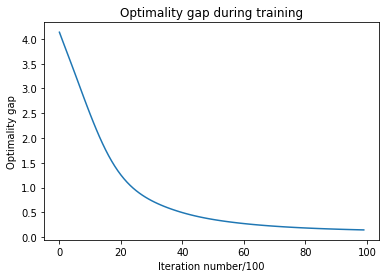

In [46]:
f = plt.figure
plt.plot(np.array(gap))
plt.title('Optimality gap during training')
plt.ylabel('Optimality gap')
plt.xlabel('Iteration number/100')